# 0. Libraries

In [240]:
# Xử lý số liệu
import numpy as np
import pandas as pd

# Thống kê & kiểm định
from scipy.stats import (
    shapiro, normaltest, probplot, boxcox, mannwhitneyu,
    kruskal, chi2_contingency, kstest, levene
)

# Tiền xử lý
from sklearn.preprocessing import PowerTransformer

# Trực quan hóa
import seaborn as sns
import matplotlib.pyplot as plt

# Cảnh báo
import warnings
warnings.filterwarnings("ignore")

In [206]:
warnings.filterwarnings ('ignore')
pd.set_option ('display.width', None)
pd.set_option ('display.max_rows', 100)
pd.set_option ('display.max_columns', 50)

In [207]:
df = pd.read_csv ('Full_Data_Reviews.csv').drop ('Unnamed: 0', axis=1)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df

,Content_cleaned,Word_Count,language_encoded,Review_Weeks_Ago,Review_Months_Ago,Review_Years_Ago,Rating_Score,label_encoded
0,đây là lần thứ 2 tôi cùng gia đình ghé thăm nh...,19,1,318,73,6,4,2
1,một show diễn tuyệt vời chạm đến cảm xúc. rất ...,16,1,11,3,0,5,2
2,"nhiệt tình, chuyên nghiệp, lần sau sẽ tiếp tục...",13,1,295,68,5,4,2
3,nơi tuyệt vời phù hợp cho cả gia đình vui chơi.,11,1,47,11,0,5,2
4,definitely will arrange with days again for ai...,9,0,91,21,1,5,2
...,...,...,...,...,...,...,...,...
10189,"tour tốt, đúng giờ và có hướng dẫn điểm đến ch...",29,1,98,23,1,5,2
10190,"trải nghiệm tuyệt vời, cảnh đêm ngoạn mục từ d...",14,1,41,9,0,5,2
10191,"đặt qua app rất nhanh, mà còn được giảm giá. t...",19,1,228,52,4,5,2
10192,tôi nghĩ nên có thêm hệ thống làm mát vì buổi ...,16,1,51,12,1,4,1


# 1. `Kolmogorov-Smirnov test` và `Shapiro-Wilk test`


**a. Shapiro-Wilk test**

- Mục đích: Kiểm định dữ liệu có phân phối chuẩn hay không?

- Shapiro-Wilk Test so sánh phân phối của dữ liệu thực tế với phân phối chuẩn lý tưởng

- H0: Dữ liệu có phân phối chuẩn

- H1: Dữ liệu không có phân phối chuẩn

- Output:

    + *statistic (SW statistic)*: 

        + Là giá trị thống kê Shapiro-Wilk (W) đo mức độ phù hợp với phân phối chuẩn. 

        + Giá trị càng gần 1 thì dữ liệu càng giống phân phối chuẩn. 

    - *p-value*

**b. Kolmogorov-Smirnov test**

- Mục đích: Kiểm định dữ liệu có phân phối chuẩn hay không?

- Kolmogorov-Smirnov Test dùng để so sánh phân phối thực tế của dữ liệu mẫu với một phân phối lý thuyết (phân phối chuẩn, đều, exponential,...) hoặc so sánh hai mẫu với nhau

- H0: Dữ liệu có tuân theo phân phối chuẩn

- H1: Dữ liệu không có tuân theo phân phối chuẩn

- Output:
    
    + *statistic (KS statistic)*
        + Là khoảng cách lớn nhất giữa

            - Phân phối tích luỹ thực nghiệm (Empirical CDF) của dữ liệu

            - Phân phối tích luỹ lý thuyết (Theoretical CDF) - ví dụ: phân phối chuẩn

        + Giá trị nằm trong khoảng [0,1]

        + Càng lớn, nghĩa là dữ liệu khác biệt nhiều với phân phối giả định

    + *p-value*: p-value nhỏ --> Bằng chứng chống lại H0 mạnh --> Dữ liệu không tuân theo phân phối giả định

## Hàm kiểm định phân phối chuẩn

In [235]:
# Hàm kiểm định phân phối chuẩn cho 1 biến
def check_normality(data, col):
    print(f"🔍 Kiểm định phân phối cho: {col}")
    
    # 1. KS-test (chuẩn hóa về Z-score)
    z = (data[col] - data[col].mean()) / data[col].std()
    ks_stat, ks_p = kstest(z, 'norm')
    print(f"→ KS-test: statistic = {ks_stat:.4f}, p = {ks_p:.10e}", 
          "→ ❌ Không có phân phối chuẩn" if ks_p < 0.05 else "→ ✅ Có thể coi là chuẩn")

    # 2. Shapiro-Wilk test (trên dữ liệu gốc) – chỉ lấy 5000 mẫu đầu
    sample = data[col].dropna()
    if len(sample) > 5000:
        sample = sample.sample(5000, random_state=42)
    shapiro_stat, shapiro_p = shapiro(sample)
    print(f"→ Shapiro-Wilk: statistic = {shapiro_stat:.4f}, p = {shapiro_p:.4e}", 
          "→ ❌ Không có phân phối chuẩn" if shapiro_p < 0.05 else "→ ✅ Có thể coi là chuẩn")

In [209]:
def transform_and_compare(df1, col):
    df = df1.copy ()
    print(f"Các kiểu biến đổi cho: {col}")
    
    x = df[col].dropna()
    transformed_cols = []

    # 1. Gốc
    df[f'{col}_orig'] = x
    print("Original:")
    check_normality(df, f'{col}_orig')
    transformed_cols.append(f'{col}_orig')

    # 2. Log(x+1)
    df[f'{col}_log'] = np.log1p(x)
    print("Log(x+1):")
    check_normality(df, f'{col}_log')
    transformed_cols.append(f'{col}_log')

    # 3. Căn bậc hai
    df[f'{col}_sqrt'] = np.sqrt(x)
    print("Căn bậc hai:")
    check_normality(df, f'{col}_sqrt')
    transformed_cols.append(f'{col}_sqrt')

    # 4. Box-Cox
    if (x <= 0).any():
        print("Không thể áp dụng Box-Cox (dữ liệu ≤ 0)")
    else:
        transformed, _ = boxcox(x)
        df[f'{col}_boxcox'] = transformed
        print("Box-Cox:")
        check_normality(df, f'{col}_boxcox')
        transformed_cols.append(f'{col}_boxcox')

    # 5. Yeo-Johnson
    yj = PowerTransformer(method='yeo-johnson')
    df[f'{col}_yeojohnson'] = yj.fit_transform(x.values.reshape(-1, 1)).flatten()
    print("Yeo-Johnson:")
    check_normality(df, f'{col}_yeojohnson')
    transformed_cols.append(f'{col}_yeojohnson')
    
    # ==== Vẽ Subplots ====
    n = len(transformed_cols)
    ncols = 3
    nrows = (n + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
    axes = axes.flatten()

    for i, colname in enumerate(transformed_cols):
        sns.histplot(df[colname], kde=True, ax=axes[i], color="skyblue")
        axes[i].set_title(colname, fontsize=12)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("")

    # Tắt các subplot dư
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    
    fig.suptitle(f'📈 Phân phối sau biến đổi: {col}', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


## Rating_Score

Các kiểu biến đổi cho: Rating_Score
Original:
🔍 Kiểm định phân phối cho: Rating_Score_orig
→ KS-test: statistic = 0.3519, p = 0.0000000000e+00 → ❌ Không có phân phối chuẩn
→ Shapiro-Wilk: statistic = 0.6853, p = 1.8593718445e-70 → ❌ Không có phân phối chuẩn
Log(x+1):
🔍 Kiểm định phân phối cho: Rating_Score_log
→ KS-test: statistic = 0.3314, p = 0.0000000000e+00 → ❌ Không có phân phối chuẩn
→ Shapiro-Wilk: statistic = 0.6363, p = 2.0197086003e-73 → ❌ Không có phân phối chuẩn
Căn bậc hai:
🔍 Kiểm định phân phối cho: Rating_Score_sqrt
→ KS-test: statistic = 0.3390, p = 0.0000000000e+00 → ❌ Không có phân phối chuẩn
→ Shapiro-Wilk: statistic = 0.6559, p = 2.8135811860e-72 → ❌ Không có phân phối chuẩn
Box-Cox:
🔍 Kiểm định phân phối cho: Rating_Score_boxcox
→ KS-test: statistic = 0.3871, p = 0.0000000000e+00 → ❌ Không có phân phối chuẩn
→ Shapiro-Wilk: statistic = 0.7066, p = 4.7690993504e-69 → ❌ Không có phân phối chuẩn
Yeo-Johnson:
🔍 Kiểm định phân phối cho: Rating_Score_yeojohnson
→ KS-test

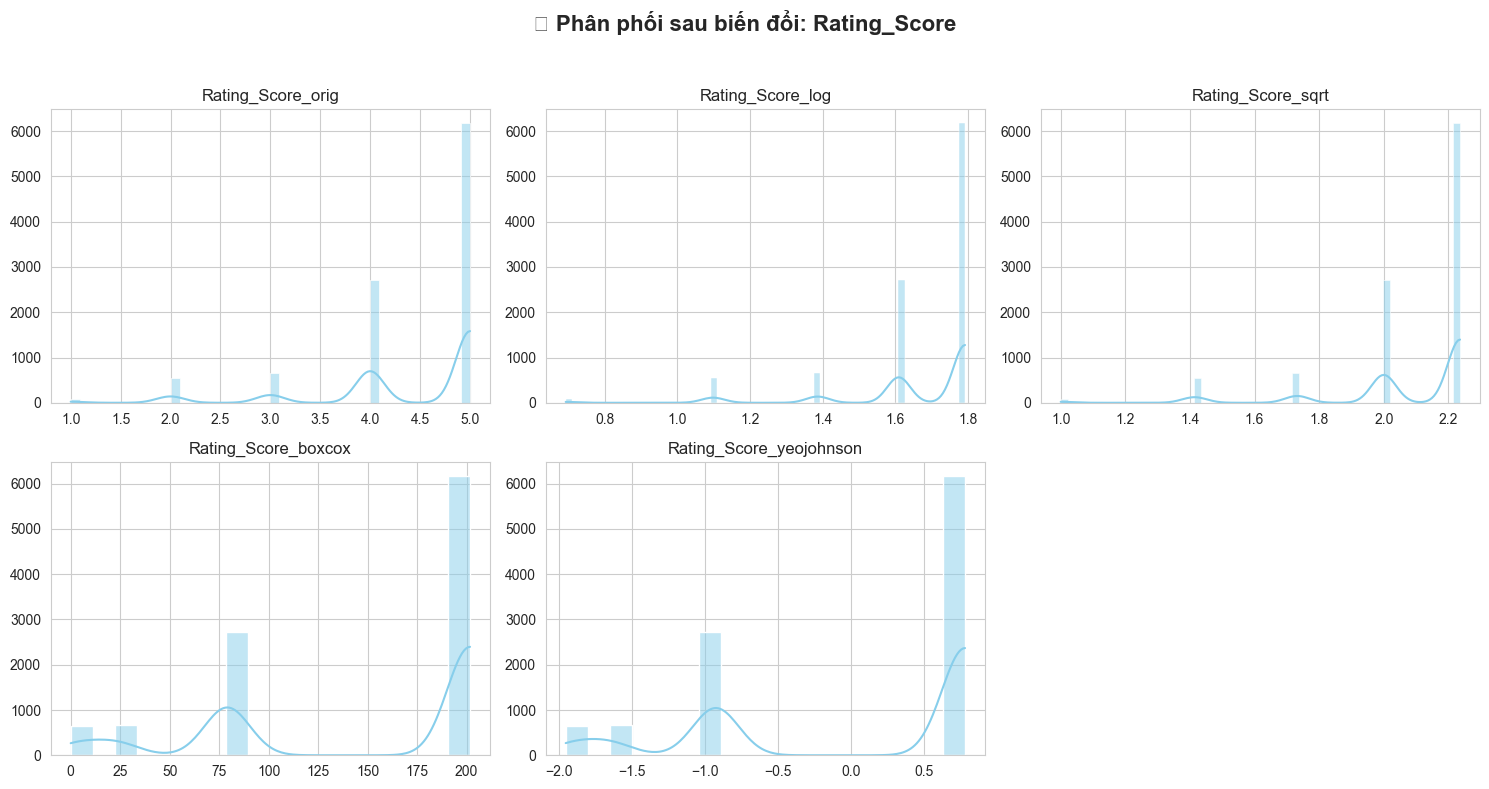

In [210]:
transform_and_compare(df, 'Rating_Score')

## Review_Years_Ago

Các kiểu biến đổi cho: Review_Years_Ago
Original:
🔍 Kiểm định phân phối cho: Review_Years_Ago_orig
→ KS-test: statistic = 0.2467, p = 0.0000000000e+00 → ❌ Không có phân phối chuẩn
→ Shapiro-Wilk: statistic = 0.8241, p = 3.4815104368e-59 → ❌ Không có phân phối chuẩn
Log(x+1):
🔍 Kiểm định phân phối cho: Review_Years_Ago_log
→ KS-test: statistic = 0.1868, p = 8.2543100095e-312 → ❌ Không có phân phối chuẩn
→ Shapiro-Wilk: statistic = 0.8622, p = 9.3217411640e-55 → ❌ Không có phân phối chuẩn
Căn bậc hai:
🔍 Kiểm định phân phối cho: Review_Years_Ago_sqrt
→ KS-test: statistic = 0.1961, p = 0.0000000000e+00 → ❌ Không có phân phối chuẩn
→ Shapiro-Wilk: statistic = 0.8644, p = 1.7951597333e-54 → ❌ Không có phân phối chuẩn
Không thể áp dụng Box-Cox (dữ liệu ≤ 0)
Yeo-Johnson:
🔍 Kiểm định phân phối cho: Review_Years_Ago_yeojohnson
→ KS-test: statistic = 0.1907, p = 0.0000000000e+00 → ❌ Không có phân phối chuẩn
→ Shapiro-Wilk: statistic = 0.8609, p = 6.2586297517e-55 → ❌ Không có phân phối chuẩn


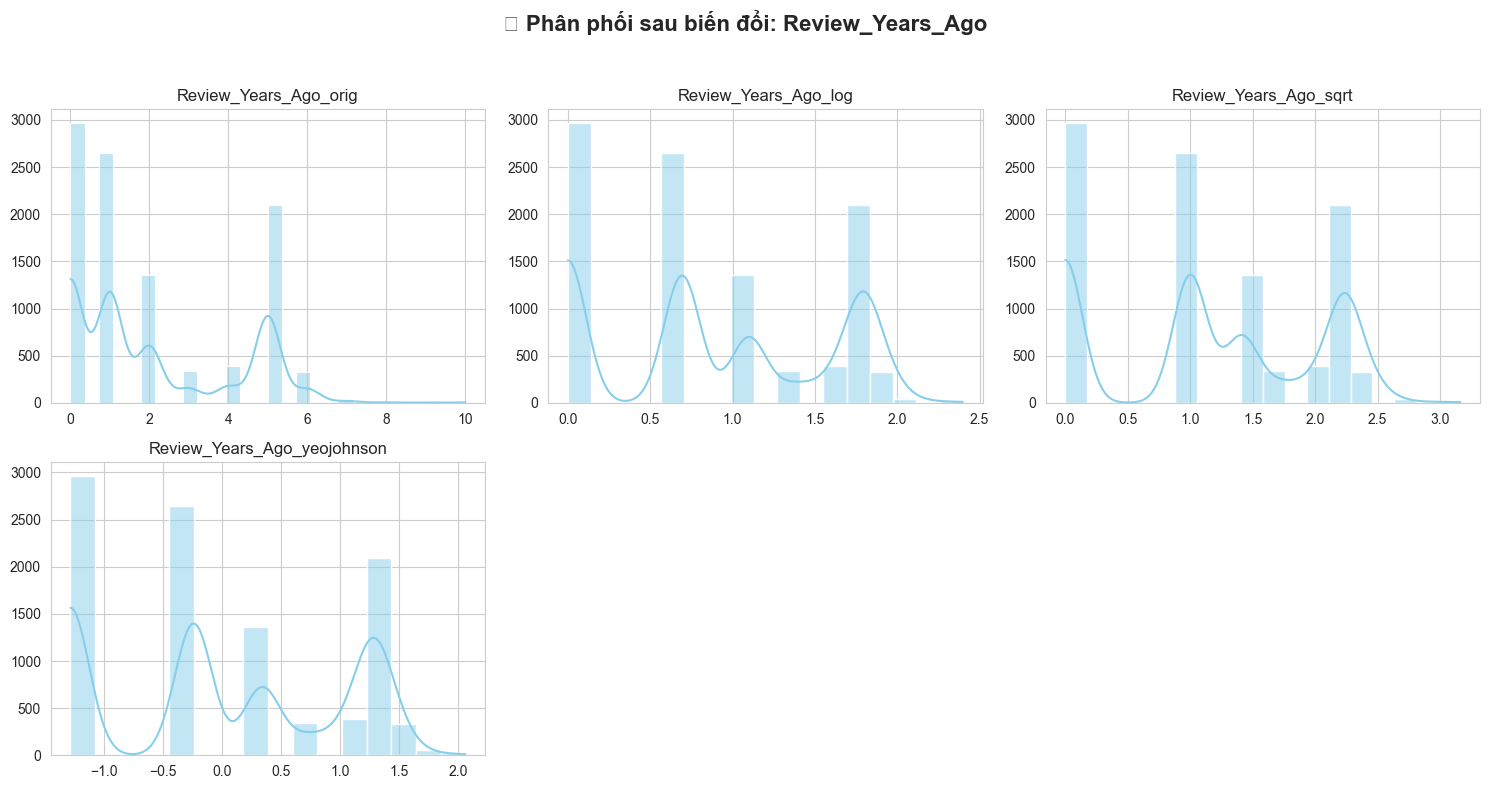

In [211]:
transform_and_compare(df, 'Review_Years_Ago')

## Review_Months_Ago

Các kiểu biến đổi cho: Review_Months_Ago
Original:
🔍 Kiểm định phân phối cho: Review_Months_Ago_orig
→ KS-test: statistic = 0.1623, p = 5.3937066217e-235 → ❌ Không có phân phối chuẩn
→ Shapiro-Wilk: statistic = 0.8540, p = 8.5582871353e-56 → ❌ Không có phân phối chuẩn
Log(x+1):
🔍 Kiểm định phân phối cho: Review_Months_Ago_log
→ KS-test: statistic = 0.1124, p = 1.4909813534e-112 → ❌ Không có phân phối chuẩn
→ Shapiro-Wilk: statistic = 0.9436, p = 4.7089422742e-40 → ❌ Không có phân phối chuẩn
Căn bậc hai:
🔍 Kiểm định phân phối cho: Review_Months_Ago_sqrt
→ KS-test: statistic = 0.1349, p = 3.6382074892e-162 → ❌ Không có phân phối chuẩn
→ Shapiro-Wilk: statistic = 0.9325, p = 8.0747133378e-43 → ❌ Không có phân phối chuẩn
Không thể áp dụng Box-Cox (dữ liệu ≤ 0)
Yeo-Johnson:
🔍 Kiểm định phân phối cho: Review_Months_Ago_yeojohnson
→ KS-test: statistic = 0.1268, p = 2.0869936710e-143 → ❌ Không có phân phối chuẩn
→ Shapiro-Wilk: statistic = 0.9468, p = 3.5618923362e-39 → ❌ Không có phân phối ch

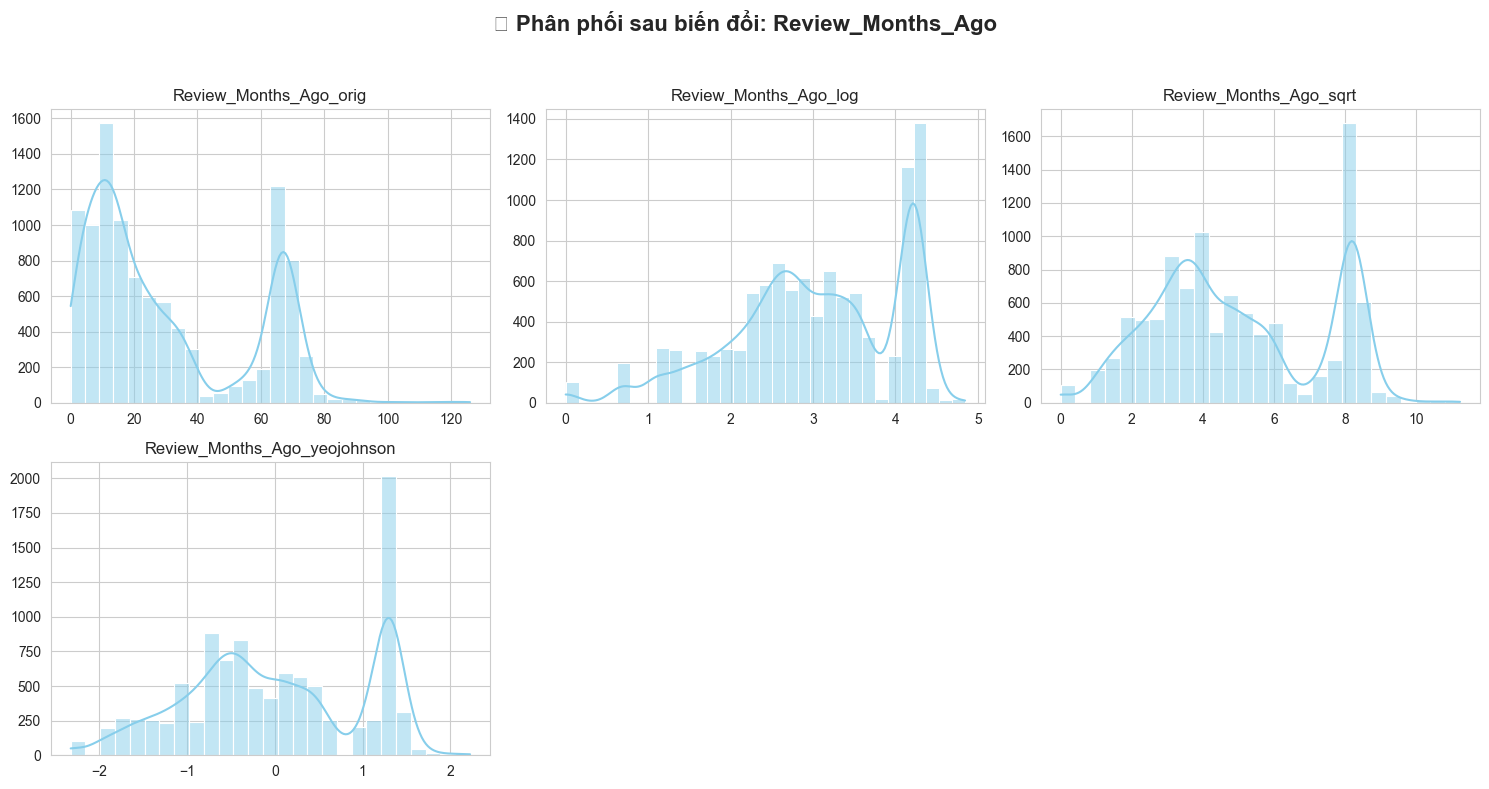

In [212]:
transform_and_compare(df, 'Review_Months_Ago')

## Review_Weeks_Ago

Các kiểu biến đổi cho: Review_Weeks_Ago
Original:
🔍 Kiểm định phân phối cho: Review_Weeks_Ago_orig
→ KS-test: statistic = 0.1582, p = 2.1684032434e-223 → ❌ Không có phân phối chuẩn
→ Shapiro-Wilk: statistic = 0.8537, p = 7.8846153585e-56 → ❌ Không có phân phối chuẩn
Log(x+1):
🔍 Kiểm định phân phối cho: Review_Weeks_Ago_log
→ KS-test: statistic = 0.1055, p = 2.5269869106e-99 → ❌ Không có phân phối chuẩn
→ Shapiro-Wilk: statistic = 0.9371, p = 9.7875665809e-42 → ❌ Không có phân phối chuẩn
Căn bậc hai:
🔍 Kiểm định phân phối cho: Review_Weeks_Ago_sqrt
→ KS-test: statistic = 0.1344, p = 3.6522849767e-161 → ❌ Không có phân phối chuẩn
→ Shapiro-Wilk: statistic = 0.9300, p = 2.0956328839e-43 → ❌ Không có phân phối chuẩn
Box-Cox:
🔍 Kiểm định phân phối cho: Review_Weeks_Ago_boxcox
→ KS-test: statistic = 0.1254, p = 3.1308586450e-140 → ❌ Không có phân phối chuẩn
→ Shapiro-Wilk: statistic = 0.9494, p = 1.8860362722e-38 → ❌ Không có phân phối chuẩn
Yeo-Johnson:
🔍 Kiểm định phân phối cho: Review_Wee

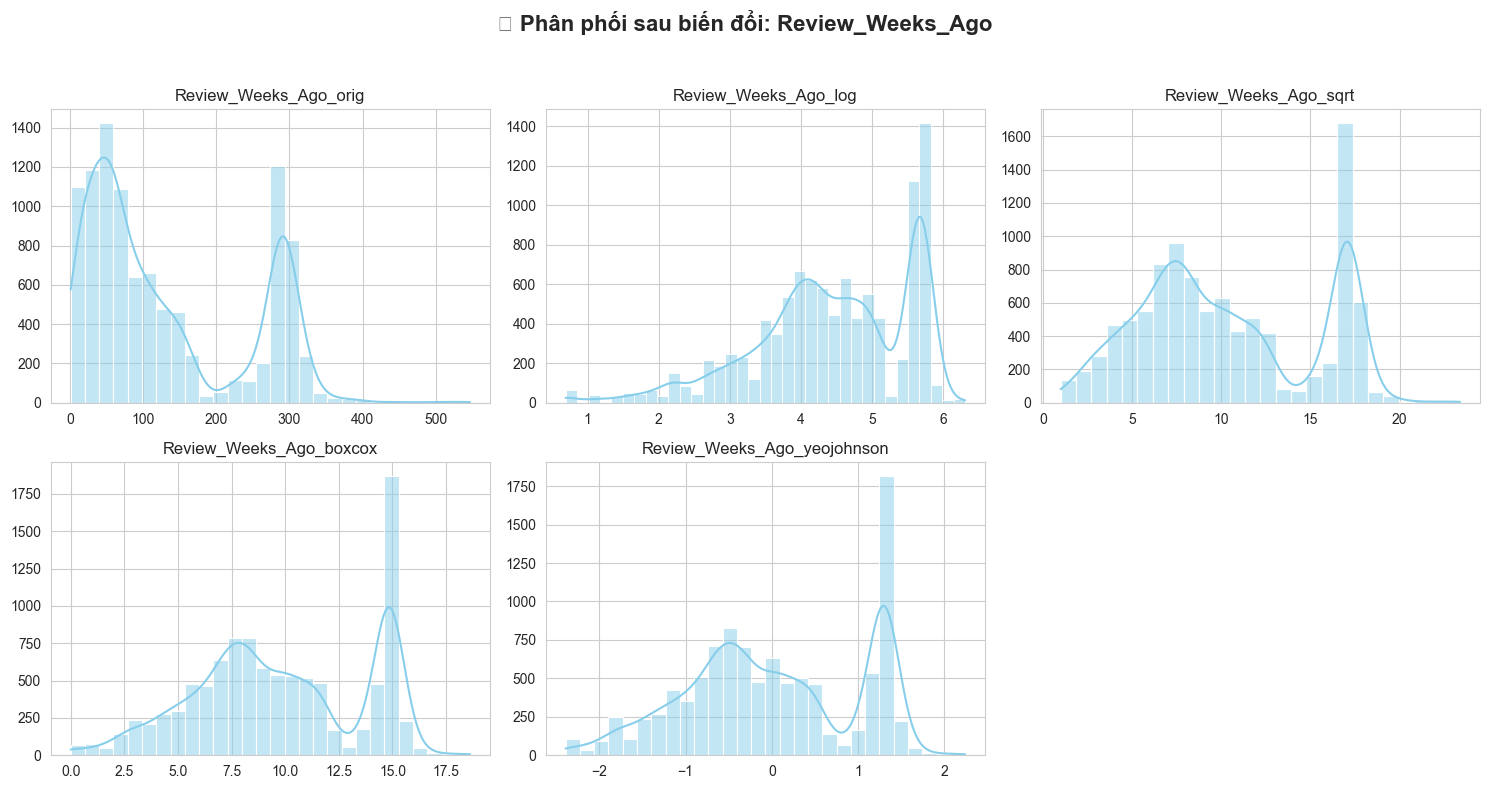

In [213]:
transform_and_compare(df, 'Review_Weeks_Ago')

## Word_Count

Các kiểu biến đổi cho: Word_Count
Original:
🔍 Kiểm định phân phối cho: Word_Count_orig
→ KS-test: statistic = 0.2105, p = 0.0000000000e+00 → ❌ Không có phân phối chuẩn
→ Shapiro-Wilk: statistic = 0.6052, p = 4.0102e-75 → ❌ Không có phân phối chuẩn
Log(x+1):
🔍 Kiểm định phân phối cho: Word_Count_log
→ KS-test: statistic = 0.0498, p = 2.0841665961e-22 → ❌ Không có phân phối chuẩn
→ Shapiro-Wilk: statistic = 0.9919, p = 2.4048e-16 → ❌ Không có phân phối chuẩn
Căn bậc hai:
🔍 Kiểm định phân phối cho: Word_Count_sqrt
→ KS-test: statistic = 0.1295, p = 1.6738017806e-149 → ❌ Không có phân phối chuẩn
→ Shapiro-Wilk: statistic = 0.8697, p = 8.9909e-54 → ❌ Không có phân phối chuẩn
Box-Cox:
🔍 Kiểm định phân phối cho: Word_Count_boxcox
→ KS-test: statistic = 0.0396, p = 2.3615134424e-14 → ❌ Không có phân phối chuẩn
→ Shapiro-Wilk: statistic = 0.9941, p = 1.7929e-13 → ❌ Không có phân phối chuẩn
Yeo-Johnson:
🔍 Kiểm định phân phối cho: Word_Count_yeojohnson
→ KS-test: statistic = 0.0397, p = 2.2985093

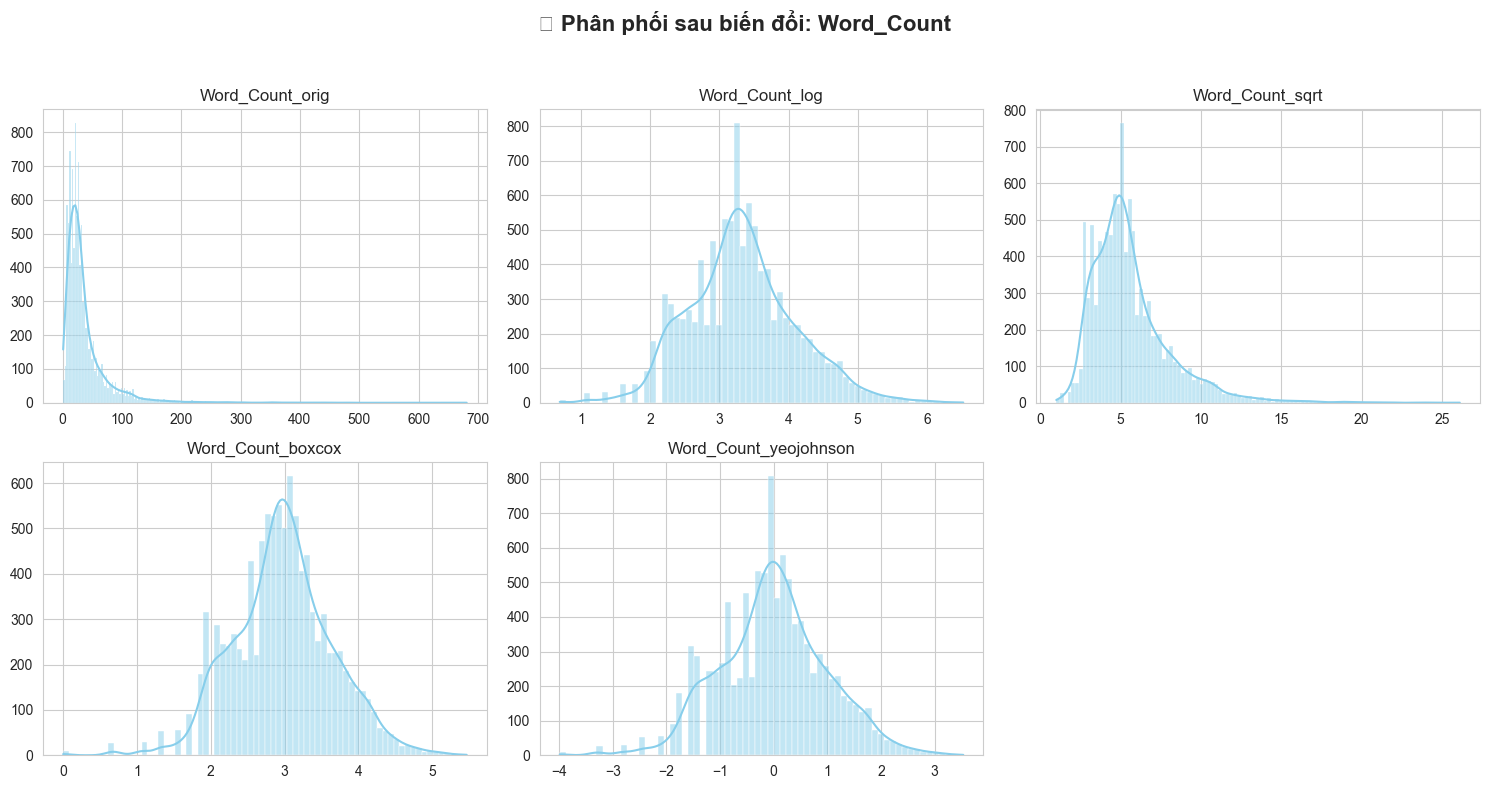

In [236]:
transform_and_compare(df, 'Word_Count')

# 2. `Levene Test`

- Là một phép kiểm định thống kê dùng để đánh giá xem nhiều nhóm dữ liệu có phương sai bằng nhau không (tức là kiểm tra đồng nhất phương sai – homogeneity of variances).

- Được thực hiện trước khi thực hiện 1 số kiểm định như ANOVA, t-test,...

- Kiểm định giả thuyết:

    + H0: Các nhóm có phương sai bằng nhau

    + H1: Có ít nhất 1 nhóm có phương sai khác biệt



In [241]:
def check_levene(df, col_value, col_group):
    """
    Thực hiện kiểm định Levene để so sánh phương sai giữa các nhóm.

    Parameters:
    - df: DataFrame chứa dữ liệu
    - col_value: tên cột giá trị số cần so sánh (ví dụ: 'Word_Count')
    - col_group: tên cột phân nhóm (ví dụ: 'label')

    Output:
    - In ra statistic và p-value
    - Diễn giải có phương sai đồng đều hay không
    """
    print(f"Levene's Test kiểm tra phương sai giữa các nhóm trong '{col_group}' cho biến '{col_value}'")

    # Lấy từng nhóm
    groups = df[col_group].dropna().unique()
    group_data = [df[df[col_group] == g][col_value].dropna() for g in groups]

    # Kiểm định Levene
    stat, p = levene(*group_data)

    print(f"Levene statistic = {stat:.4f}, p = {p:.4e}")
    if p >= 0.05:
        print("Không có sự khác biệt đáng kể về phương sai giữa các nhóm (phương sai đồng đều)")
    else:
        print("Có sự khác biệt về phương sai giữa các nhóm (phương sai không đồng đều)")
    print ()

In [242]:
check_levene(df, col_value='Rating_Score', col_group='label_encoded')
check_levene(df, col_value='Review_Years_Ago', col_group='label_encoded')
check_levene(df, col_value='Review_Months_Ago', col_group='label_encoded')
check_levene(df, col_value='Review_Weeks_Ago', col_group='label_encoded')
check_levene(df, col_value='Word_Count', col_group='label_encoded')

Levene's Test kiểm tra phương sai giữa các nhóm trong 'label_encoded' cho biến 'Rating_Score'
Levene statistic = 1169.1370, p = 0.0000e+00
Có sự khác biệt về phương sai giữa các nhóm (phương sai không đồng đều)

Levene's Test kiểm tra phương sai giữa các nhóm trong 'label_encoded' cho biến 'Review_Years_Ago'
Levene statistic = 22.7685, p = 1.3608e-10
Có sự khác biệt về phương sai giữa các nhóm (phương sai không đồng đều)

Levene's Test kiểm tra phương sai giữa các nhóm trong 'label_encoded' cho biến 'Review_Months_Ago'
Levene statistic = 23.9778, p = 4.0833e-11
Có sự khác biệt về phương sai giữa các nhóm (phương sai không đồng đều)

Levene's Test kiểm tra phương sai giữa các nhóm trong 'label_encoded' cho biến 'Review_Weeks_Ago'
Levene statistic = 23.8458, p = 4.6565e-11
Có sự khác biệt về phương sai giữa các nhóm (phương sai không đồng đều)

Levene's Test kiểm tra phương sai giữa các nhóm trong 'label_encoded' cho biến 'Word_Count'
Levene statistic = 179.4583, p = 2.5309e-77
Có sự khá

# 3. `Kruskal-Wallis Test`

- Là kiểm định phi tham số (non-parametric test), dùng để so sánh trung vị của từ 2 nhóm trở lên

- Kiểm định xem giữa các nhóm có khác biệt thống kê hay không

- Là phiên bản mở rộng của kiểm định Mann-Whitney U Test (dùng cho 2 nhóm)

- Dùng Kruskal-Wallis khi:

    + Biến phụ thuộc: continuous hoặc ordinal

    + Biến độc lập: Categorical

    + Dữ liệu không đồng nhất phương sai và không đảm bảo điều kiện của ANOVA.

- Giả thuyết kiểm định:

    + H0: Các nhóm có cùng phân phối (trung vị của các nhóm bằng nhau)

    + H1: Có ít nhất 1 nhóm có trung vị khác biệt với nhóm còn lại.

`Cách tính toán:`

   + **Gộp toàn bộ dữ liệu từ tất cả các nhóm** vào thành một mảng duy nhất.

   + **Sắp xếp các giá trị theo thứ tự tăng dần và gán hạng (rank)**:

      - Giá trị nhỏ nhất được hạng 1, lớn nhất được hạng *N*.

      - Nếu có các giá trị trùng nhau, mỗi giá trị được gán trung bình thứ hạng.

   + **Tính tổng hạng (sum of ranks)** cho từng nhóm:

   - Với nhóm thứ *i*, gọi tổng hạng là \( R_i \), số phần tử là \( n_i \).

   + **Tính thống kê kiểm định Kruskal–Wallis (H)** theo công thức:

$$
H = \frac{12}{N(N+1)} \sum_{i=1}^{k} \frac{R_i^2}{n_i} - 3(N+1)
$$

---

`Phân phối và diễn giải`

- Khi giả thuyết không (H₀) đúng, thống kê \( H \) **xấp xỉ phân phối chi bình phương (chi-square)** với **bậc tự do**:

$$
\text{df} = k - 1
$$

- Từ giá trị \( H \), tra phân phối chi bình phương để lấy **p-value** tương ứng.

---

`Diễn giải:`

| p-value | Kết luận |
|---------|----------|
| $ p > 0.05 $ | **Không bác bỏ H₀** → Không có bằng chứng rằng trung vị giữa các nhóm khác nhau |
| $ p \leq 0.05 $ | **Bác bỏ H₀** → Có **ít nhất một nhóm** có trung vị khác biệt |

> Ghi chú: Nếu bác bỏ H₀, bạn nên tiếp tục thực hiện kiểm định hậu kiểm (post-hoc test), chẳng hạn **Dunn’s Test** để xác định **nhóm nào khác biệt** với nhóm còn lại.


- `H (Kruskal-Wallis Statistic)`: Đây là giá trị thống kê H, phản ánh mức độ khác biệt thứ hạng giữa các nhóm. Nó càng lớn thì sự khác biệt càng rõ ràng.

- `p-value`: Xác suất để giá trị H thu được nếu xảy ra giả thuyết H0 đúng (tức là nếu thực sự không có sự khác biệt). Nếu p < 0.05 --> Có ý nghĩa thống kê.

In [215]:
def kruskal_test(df, value_col, group_col):
    """
    Thực hiện Kruskal-Wallis Test để so sánh giá trị trung vị giữa nhiều nhóm không phân phối chuẩn.

    Tham số:
    - df: DataFrame chứa dữ liệu
    - value_col: tên cột số (biến định lượng, ví dụ: 'Word_Count')
    - group_col: tên cột nhóm (biến phân loại, ví dụ: 'label')

    Kết quả:
    - In thống kê và kết luận
    """
    print(f"🔍 Kruskal-Wallis Test cho biến '{value_col}' theo nhóm '{group_col}'")

    # Tách dữ liệu thành danh sách các nhóm
    groups = df[group_col].unique()
    data_by_group = [df[df[group_col] == g][value_col].dropna() for g in groups]

    # Thực hiện kiểm định
    stat, p = kruskal(*data_by_group)

    print(f"→ H = {stat:.4f}, p = {p:.10e}")
    if p < 0.05:
        print("→ ❗ Có sự khác biệt ý nghĩa giữa các nhóm")
    else:
        print("→ ✅ Không có sự khác biệt đáng kể giữa các nhóm")

## a. Rating_Score - label

- Có sự khác biệt ý nghĩa thống kê về điểm đánh giá Rating_Score giữa các nhóm cảm xúc (POS, NEU, NEG) hay không

- H0: Trung vị của Rating_Score là bằng nhau giữa các nhóm cảm xúc (Ví dụ như đều quanh mức 3.0 — nhưng không cần biết chính xác là bao nhiêu.)

- H1: Có ít nhất 1 nhóm có trung vị Rating_Score khác biệt với các nhóm còn lại

🔍 Kruskal-Wallis Test cho biến 'Rating_Score' theo nhóm 'label_encoded'
→ H = 4658.6677, p = 0.0000000000e+00
→ ❗ Có sự khác biệt ý nghĩa giữa các nhóm


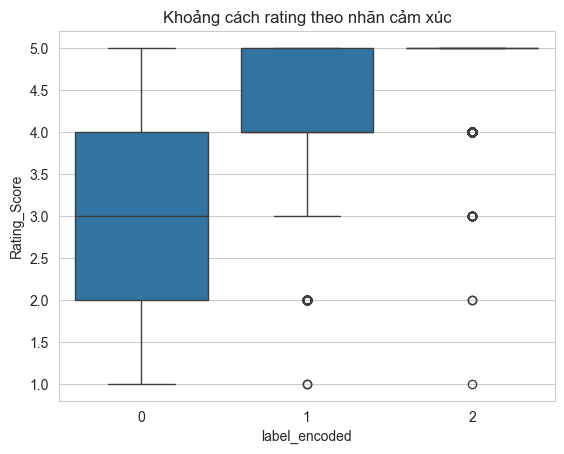

In [216]:
kruskal_test(df, value_col='Rating_Score', group_col='label_encoded')
sns.boxplot(x='label_encoded', y='Rating_Score', data=df)
plt.title("Khoảng cách rating theo nhãn cảm xúc")
plt.show()

## b. Review_Years_Ago - label

- Có sự khác biệt có ý nghĩa thống kê về thời điểm viết reviews (tính theo số năm trước) giữa các nhóm cảm xúc hay không?

- H0: Trung vị của Review_Years_Ago giống nhau giữa các nhóm cảm xúc

- H1: Có ít nhất 1 nhóm cảm xúc có trung vị Review_Years_Ago khác biệt với nhóm khác

- Nếu H0 đúng --> Thời gian mà người dùng viết review **không ảnh hưởng đáng kể** đến cảm xúc trong review của họ --> Mọi khác biệt về thời gian chỉ là **ngẫu nhiên, không đáng kể**

- Nếu H1 đúng --> Có sự khác biệt có ý nghĩa thống kê về thời điểm viết review giữa các nhóm cảm xúc.

🔍 Kruskal-Wallis Test cho biến 'Review_Years_Ago' theo nhóm 'label_encoded'
→ H = 72.6473, p = 1.6782031871e-16
→ ❗ Có sự khác biệt ý nghĩa giữa các nhóm


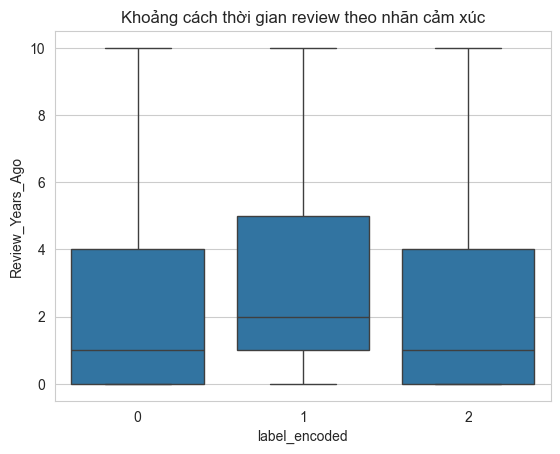

In [217]:
kruskal_test(df, value_col='Review_Years_Ago', group_col='label_encoded')
sns.boxplot(x='label_encoded', y='Review_Years_Ago', data=df)
plt.title("Khoảng cách thời gian review theo nhãn cảm xúc")
plt.show()

Kết quả kiểm định Kruskal-Wallis cho thấy có sự khác biệt có ý nghĩa thống kê (p < 0.001) về thời điểm đánh giá (Review_Years_Ago) giữa các nhóm cảm xúc (label).
Điều này cho thấy rằng mức độ cảm xúc người dùng có thể thay đổi theo thời gian, ví dụ:

Người viết đánh giá cách đây lâu hơn có xu hướng ghi lại trải nghiệm tiêu cực nhiều hơn (NEG),

Trong khi những người review gần đây hơn lại thường mang cảm xúc tích cực hơn (POS).

## c. Review_Months_Ago - label

🔍 Kruskal-Wallis Test cho biến 'Review_Months_Ago' theo nhóm 'label_encoded'
→ H = 66.6938, p = 3.2932254955e-15
→ ❗ Có sự khác biệt ý nghĩa giữa các nhóm


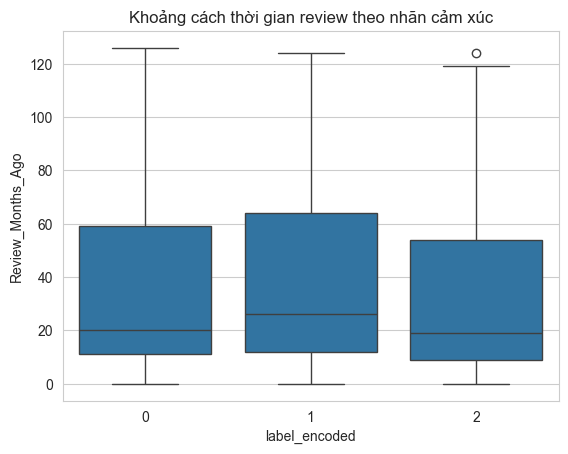

In [218]:
kruskal_test(df, value_col='Review_Months_Ago', group_col='label_encoded')
sns.boxplot(x='label_encoded', y='Review_Months_Ago', data=df)
plt.title("Khoảng cách thời gian review theo nhãn cảm xúc")
plt.show()

## d. Review_Weeks_Ago - label

🔍 Kruskal-Wallis Test cho biến 'Review_Weeks_Ago' theo nhóm 'label_encoded'
→ H = 67.3430, p = 2.3804693368e-15
→ ❗ Có sự khác biệt ý nghĩa giữa các nhóm


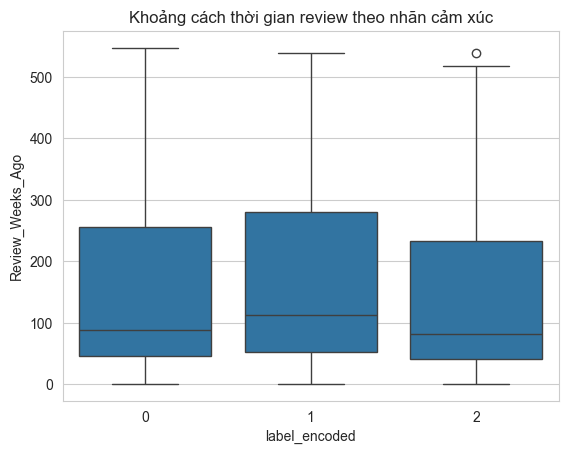

In [219]:
kruskal_test(df, value_col='Review_Weeks_Ago', group_col='label_encoded')
sns.boxplot(x='label_encoded', y='Review_Weeks_Ago', data=df)
plt.title("Khoảng cách thời gian review theo nhãn cảm xúc")
plt.show()

## e. Word_Count - label

- Có sự khác biệt có ý nghĩa thống kê về độ dài review (tính theo số từ) giữa các nhóm cảm xúc không?

- H0: Trung vị của Word_Count là giống nhau giữa các nhóm cảm xúc

- H1: Có ít nhất một nhóm cảm xúc có trung vị Word_Count khác biệt với nhóm còn lại.

- Nếu H0 đúng --> Số từ trong review không liên quan đến cảm xúc mà người viết thể hiện. (Ví dụ: người viết cảm xúc tích cực hay tiêu cực cũng viết dài ngắn như nhau, sự khác biệt (nếu có) chỉ là ngẫu nhiên.)

- Nếu H1 đúng --> Độ dài review phụ thuộc vào cảm xúc:

    + Có thể review tiêu cực thường ngắn gọn, xúc tích.

    + Hoặc review tích cực thường dài hơn vì người dùng chia sẻ chi tiết trải nghiệm tốt.

    + Hoặc nhóm trung lập (NEU) lại viết ít từ nhất.

🔍 Kruskal-Wallis Test cho biến 'Word_Count' theo nhóm 'label_encoded'
→ H = 262.9597, p = 7.9253096888e-58
→ ❗ Có sự khác biệt ý nghĩa giữa các nhóm


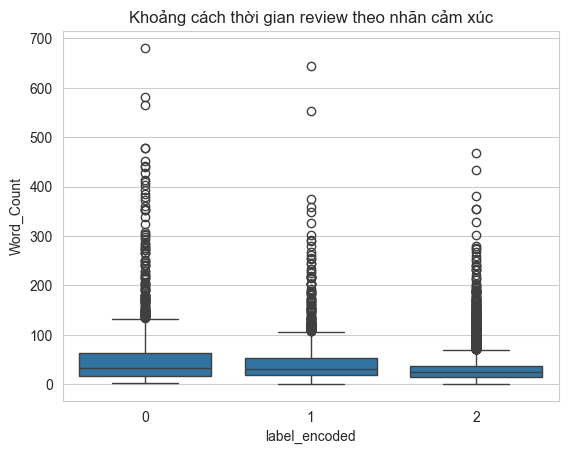

In [220]:
kruskal_test(df, value_col='Word_Count', group_col='label_encoded')
sns.boxplot(x='label_encoded', y='Word_Count', data=df)
plt.title("Khoảng cách thời gian review theo nhãn cảm xúc")
plt.show()

Kết quả kiểm định Kruskal-Wallis cho thấy có sự khác biệt có ý nghĩa thống kê (p < 0.001) về độ dài bài đánh giá (số từ) giữa các nhóm cảm xúc (NEG, NEU, POS).
Điều này cho thấy người dùng viết review dài/ngắn khác nhau tùy theo cảm xúc họ thể hiện.

In [221]:
import pingouin as pg
pg.kruskal(data=df, dv='Word_Count', between='label_encoded')

,Source,ddof1,H,p-unc
Kruskal,label_encoded,2,262.959748,7.925310e-58


- `ddof1 (Degrees of freedom)`: Bậc tự do = Số nhóm - 1

- `H`: Kruskal-Wallis H Statistic: Chỉ số đo mức độ khác biệt thứ hạng giữa các nhóm

- `p-unc`: p-value chưa hiệu chỉnh

In [222]:
# import pandas as pd
# from scipy.stats import kruskal
# import scikit_posthocs as sp
# import itertools

# def run_kruskal_and_dunn(df, value_col, group_col, p_adjust_method='bonferroni'):
#     print(f"🔍 Kruskal-Wallis Test cho biến '{value_col}' theo nhóm '{group_col}'")

#     # Tách dữ liệu theo nhóm
#     groups = df[group_col].unique()
#     data_by_group = [df[df[group_col] == g][value_col].dropna() for g in groups]

#     # Kruskal-Wallis Test
#     H_stat, p_val = kruskal(*data_by_group)
#     print(f"→ H = {H_stat:.4f}, p = {p_val:.10f}")

#     if p_val < 0.05:
#         print("→ ❗ Có sự khác biệt thống kê giữa ít nhất một cặp nhóm. Thực hiện post-hoc Dunn Test...\n")

#         # Post-hoc Dunn test
#         posthoc = sp.posthoc_dunn(df, val_col=value_col, group_col=group_col, p_adjust=p_adjust_method)

#         # Hiển thị kết quả dễ đọc
#         pairs = list(itertools.combinations(groups, 2))
#         for g1, g2 in pairs:
#             p_adj = posthoc.loc[g1, g2]
#             result = "❌ KHÁC BIỆT" if p_adj < 0.05 else "✅ Không khác biệt"
#             print(f"{g1} vs {g2} → p_adj = {p_adj:.5f} ({result})")

#         return posthoc
#     else:
#         print("→ ✅ Không có sự khác biệt đáng kể giữa các nhóm.")
#         return None
# run_kruskal_and_dunn(df, value_col='Word_Count', group_col='label_encoded', p_adjust_method='holm')

In [223]:
# run_kruskal_and_dunn(df, value_col='Rating_Score', group_col='label_encoded', p_adjust_method='holm')

# 4. `Mann-Whitney U Test`

- Là một kiểm định phi tham số dùng để so sánh sự khác biệt về phân phối (chủ yếu là trung vị) giữa hai nhóm độc lập.

- Kiểm tra xem hai mẫu độc lập có đến từ cùng một phân phối hay không, khi không thể giả định phân phối chuẩn như trong kiểm định t-test.

- Sử dụng khi:

    + Có 2 nhóm độc lập

    + Biến phụ thuộc: Continuous hoặc Ordinal

    + Không thể giả định phân phối chuẩn hoặc dữ liệu có ngoại lệ --> Không dùng được t-test

- H0: Hai nhóm có cùng phân phối (tức là trung vị giống nhau)

- H1: Một nhóm có phân phối khác so với nhóm còn lại (trung vị khác biệt).

- Giả sử:

    - Nhóm 1 có kích thước $n_1$, tổng hạng $R_1$

    - Nhóm 2 có kích thước $n_2$, tổng hạng $R_2$

- Công thức tính hai giá trị U:
$$
U_1 = R_1 - \frac{n_1(n_1 + 1)}{2}
$$
$$
U_2 = R_2 - \frac{n_2(n_2 + 1)}{2}
$$

- Thống kê kiểm định:

$$
U = \min(U_1, U_2)
$$
- Khi kích thước mẫu đủ lớn, có thể chuyển sang z-score
$$
Z = \frac{U - \mu_U}{\sigma_U}
$$

trong đó:
$$
\mu_U = \frac{n_1 n_2}{2}
$$
$$
\sigma_U = \sqrt{ \frac{n_1 n_2 (n_1 + n_2 + 1)}{12} }
$$
Sau đó, dùng Z để tra bảng phân phối chuẩn chuẩn hoá để tính p-value.

In [224]:
def mann_whitney_test(df, value_col, group_col, group1, group2, alternative='two-sided'):
    """
    Mann-Whitney U Test giữa hai nhóm (ổn định hơn, có kiểm tra lỗi).
    """
    x = df[df[group_col] == group1][value_col].dropna()
    y = df[df[group_col] == group2][value_col].dropna()

    print(f"Mann-Whitney U test giữa nhóm '{group1}' và '{group2}' cho biến '{value_col}'")
    print(f"→ Số lượng: {len(x)} vs {len(y)}")

    # Kiểm tra dữ liệu đủ lớn
    if len(x) < 2 or len(y) < 2:
        print("Không đủ dữ liệu (mỗi nhóm cần ít nhất 2 mẫu)")
        return

    # Thử thực hiện kiểm định
    try:
        stat, p = mannwhitneyu(x, y, alternative=alternative)

        if np.isnan(stat) or np.isnan(p):
            print("Thống kê U hoặc p-value bị NaN. Có thể do hai nhóm có giá trị giống hệt nhau.")
            return

        print(f"→ U = {stat:.4f}, p = {p:.10e}")
        if p < 0.05:
            print("Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm")
        else:
            print("Không có sự khác biệt đáng kể giữa hai nhóm")

    except Exception as e:
        print(f"Lỗi trong quá trình kiểm định: {e}")

## a. Rating_Score - label

In [225]:
mann_whitney_test(df, value_col='Rating_Score', group_col='label_encoded', group1=0, group2=1)
mann_whitney_test(df, value_col='Rating_Score', group_col='label_encoded', group1=1, group2=2)
mann_whitney_test(df, value_col='Rating_Score', group_col='label_encoded', group1=2, group2=0)

Mann-Whitney U test giữa nhóm '0' và '1' cho biến 'Rating_Score'
→ Số lượng: 1450 vs 1744
→ U = 526841.0000, p = 2.0896519224e-195
Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm
Mann-Whitney U test giữa nhóm '1' và '2' cho biến 'Rating_Score'
→ Số lượng: 1744 vs 7000
→ U = 2749301.5000, p = 0.0000000000e+00
Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm
Mann-Whitney U test giữa nhóm '2' và '0' cho biến 'Rating_Score'
→ Số lượng: 7000 vs 1450
→ U = 9462776.5000, p = 0.0000000000e+00
Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm


## b. Review_Years_Ago - label

In [226]:
mann_whitney_test(df, value_col='Review_Years_Ago', group_col='label_encoded', group1=0, group2=1)
mann_whitney_test(df, value_col='Review_Years_Ago', group_col='label_encoded', group1=1, group2=2)
mann_whitney_test(df, value_col='Review_Years_Ago', group_col='label_encoded', group1=2, group2=0)

Mann-Whitney U test giữa nhóm '0' và '1' cho biến 'Review_Years_Ago'
→ Số lượng: 1450 vs 1744
→ U = 1145598.5000, p = 2.7080428735e-06
Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm
Mann-Whitney U test giữa nhóm '1' và '2' cho biến 'Review_Years_Ago'
→ Số lượng: 1744 vs 7000
→ U = 6882443.0000, p = 2.2016691506e-17
Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm
Mann-Whitney U test giữa nhóm '2' và '0' cho biến 'Review_Years_Ago'
→ Số lượng: 7000 vs 1450
→ U = 4894279.5000, p = 2.7797755525e-02
Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm


## c. Review_Months_Ago - label

In [227]:
mann_whitney_test(df, value_col='Review_Months_Ago', group_col='label_encoded', group1=0, group2=1)
mann_whitney_test(df, value_col='Review_Months_Ago', group_col='label_encoded', group1=1, group2=2)
mann_whitney_test(df, value_col='Review_Months_Ago', group_col='label_encoded', group1=2, group2=0)

Mann-Whitney U test giữa nhóm '0' và '1' cho biến 'Review_Months_Ago'
→ Số lượng: 1450 vs 1744
→ U = 1152638.0000, p = 1.6453513202e-05
Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm
Mann-Whitney U test giữa nhóm '1' và '2' cho biến 'Review_Months_Ago'
→ Số lượng: 1744 vs 7000
→ U = 6870559.0000, p = 4.3218649079e-16
Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm
Mann-Whitney U test giữa nhóm '2' và '0' cho biến 'Review_Months_Ago'
→ Số lượng: 7000 vs 1450
→ U = 4884918.0000, p = 2.4522013392e-02
Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm


## d. Review_Weeks_Ago - label

In [228]:
mann_whitney_test(df, value_col='Review_Weeks_Ago', group_col='label_encoded', group1=0, group2=1)
mann_whitney_test(df, value_col='Review_Weeks_Ago', group_col='label_encoded', group1=1, group2=2)
mann_whitney_test(df, value_col='Review_Weeks_Ago', group_col='label_encoded', group1=2, group2=0)

Mann-Whitney U test giữa nhóm '0' và '1' cho biến 'Review_Weeks_Ago'
→ Số lượng: 1450 vs 1744
→ U = 1153560.0000, p = 1.9397337048e-05
Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm
Mann-Whitney U test giữa nhóm '1' và '2' cho biến 'Review_Weeks_Ago'
→ Số lượng: 1744 vs 7000
→ U = 6873831.5000, p = 3.2912509645e-16
Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm
Mann-Whitney U test giữa nhóm '2' và '0' cho biến 'Review_Weeks_Ago'
→ Số lượng: 7000 vs 1450
→ U = 4878471.5000, p = 2.0093009045e-02
Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm


## e. Word_Count - label

In [229]:
mann_whitney_test(df, value_col='Word_Count', group_col='label_encoded', group1=0, group2=1)
mann_whitney_test(df, value_col='Word_Count', group_col='label_encoded', group1=1, group2=2)
mann_whitney_test(df, value_col='Word_Count', group_col='label_encoded', group1=2, group2=0)

Mann-Whitney U test giữa nhóm '0' và '1' cho biến 'Word_Count'
→ Số lượng: 1450 vs 1744
→ U = 1300221.5000, p = 1.6738603703e-01
Không có sự khác biệt đáng kể giữa hai nhóm
Mann-Whitney U test giữa nhóm '1' và '2' cho biến 'Word_Count'
→ Số lượng: 1744 vs 7000
→ U = 7296916.5000, p = 1.1190265635e-36
Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm
Mann-Whitney U test giữa nhóm '2' và '0' cho biến 'Word_Count'
→ Số lượng: 7000 vs 1450
→ U = 4035769.5000, p = 9.7085461757e-35
Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm


## f. Word_Count - language

- Có sự khác biệt ý nghĩa thống kê về độ dài review (tính theo số từ) giữa hai ngôn ngữ là tiếng Việt và tiếng Anh không?

- H0: Trung vị Word_Count là giống nhau giữa review tiếng Việt (vi) và tiếng Anh (en).

- H1: Có sự khác biệt có ý nghĩa thống kê về trung vị Word_Count giữa hai ngôn ngữ.

- Nếu H0 đúng: Review viết bằng tiếng Việt và tiếng Anh có độ dài tương đương nhau (về trung vị) và sự khác biệt (nếu có) chỉ là do ngẫu nhiên

- Nếu H1 đúng: Có bằng chứng cho thấy một trong hai ngôn ngữ viết review dài hơn (về trung vị) (có thể review tiếng Anh dài hơn tiếng Việt)

In [230]:
mann_whitney_test(df, value_col='Word_Count', group_col='language_encoded', group1=0, group2=1)

Mann-Whitney U test giữa nhóm '0' và '1' cho biến 'Word_Count'
→ Số lượng: 3663 vs 6531
→ U = 16139349.5000, p = 7.6593662997e-189
Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm


## g. Rating_Score - language

In [231]:
mann_whitney_test(df, value_col='Rating_Score', group_col='language_encoded', group1=0, group2=1)

Mann-Whitney U test giữa nhóm '0' và '1' cho biến 'Rating_Score'
→ Số lượng: 3663 vs 6531
→ U = 15415250.5000, p = 2.9190792313e-170
Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm


# 5. `Chi-Squared Test (χ²)`

- Là một kiểm định thống kê nhằm kiểm tra sự khác biệt giữa **tần suất quan sát** và **tần suất kỳ vọng** trong dữ liệu phân loại. 

- Nó thường dùng để kiểm định:

    + **Chi-Squared Test of Independence**: Kiểm tra sự độc lập giữa hai biến phân loại.

    + **Chi-Squared Goodness of Fit**: Kiểm tra sự phù hợp của phân phối thực tế so với phân phối kỳ vọng.

- Giả thuyết kiểm định:

    + H0: Hai biến phân loại là độc lập --> Không có mối liên hệ giữa chúng

    + H1: Hai biến có mối liên hệ thống kê --> Không độc lập

- Công thức kiểm định Chi-Squared

    + Giả sử có bảng đếm (contingency table) gồm các ô $(i, j)$, trong đó:

        - $ O_{ij} $: tần suất **quan sát được** tại ô (i, j)
        - $ E_{ij} $: tần suất **kỳ vọng** tại ô (i, j), tính bằng:

        $$
        E_{ij} = \frac{(\text{Tổng hàng i}) \times (\text{Tổng cột j})}{\text{Tổng toàn bộ mẫu}}
        $$

    + Khi đó, thống kê kiểm định Chi-squared được tính bằng:

        $$
        \chi^2 = \sum_{i=1}^{r} \sum_{j=1}^{c} \frac{(O_{ij} - E_{ij})^2}{E_{ij}}
        $$

    + Trong đó:
        - $ r $: số hàng (giá trị của biến thứ nhất)
        - $ c $: số cột (giá trị của biến thứ hai)

In [232]:
def chi_squared_test(df, col1, col2):
    """
    Thực hiện kiểm định Chi-Squared giữa hai biến phân loại.
    
    Tham số:
    - df: DataFrame chứa dữ liệu
    - col1, col2: tên 2 cột phân loại cần kiểm định
    
    Kết quả:
    - In ra bảng tần suất, giá trị statistic và p-value, kèm diễn giải
    """
    print(f"Kiểm định Chi-Squared giữa '{col1}' và '{col2}'")
    
    # Tạo bảng chéo (contingency table)
    table = pd.crosstab(df[col1], df[col2])
    print("Bảng chéo (Contingency Table):")
    print(table)
    
    # Thực hiện kiểm định
    chi2, p, dof, expected = chi2_contingency(table)
    
    print(f"Chi-squared = {chi2:.4f}, p = {p:.10e}, df = {dof}")
    
    if p < 0.05:
        print("Có mối liên hệ có ý nghĩa thống kê giữa hai biến.")
    else:
        print("Không có bằng chứng về mối liên hệ đáng kể giữa hai biến.")

In [233]:
chi_squared_test(df, col1='label_encoded', col2='language_encoded')

Kiểm định Chi-Squared giữa 'label_encoded' và 'language_encoded'
Bảng chéo (Contingency Table):
language_encoded     0     1
label_encoded               
0                  309  1141
1                  354  1390
2                 3000  4000
Chi-squared = 465.6435, p = 7.7055224912e-102, df = 2
Có mối liên hệ có ý nghĩa thống kê giữa hai biến.


**Kết luận**: 

- Cảm xúc review có liên quan đáng kể đến ngôn ngữ viết review (Tiếng Việt hoặc tiếng Anh)

- Người dùng viết review bằng tiếng Việt và tiếng Anh không có phân bố cảm xúc giống nhau